In [1]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.font_manager.fontManager.addfont('./NotoSansTC-VariableFont_wght.ttf')
matplotlib.rc('font', family='Noto Sans TC', weight='400')

data = StringIO("""列標籤,平均值 - CTR（全部）,平均值 - CPC（單次連結點擊成本）
FB Reels,3.990349248,1.739994337
FB Reels 廣告,0.274348423,4
FB 限時動態,3.81338454,3.118421055
FB 動態,5.483668265,1.515540173
FB 插播 Reel,3.846153845,1.8
IG 限時動態,2.815555103,4.30032733
IG 動態,5.03179218,2.51446639
IG 探索,2.127659575,1.66666667
"""
)

df = pd.read_csv(data)

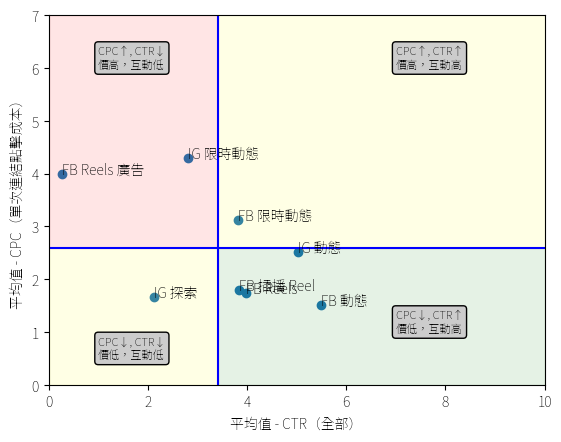

In [2]:
fig, ax = plt.subplots()

ctr_mean = df[df.columns[1]].mean()
ctr_max = df[df.columns[1]].max()
cpc_mean = df[df.columns[2]].mean()
cpc_max = df[df.columns[2]].max()

ax.scatter(df[df.columns[1]], df[df.columns[2]])
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.set_xlabel(df.columns[1])
ax.set_ylabel(df.columns[2])
ax.vlines(ctr_mean, 0, 20, colors='blue')
ax.hlines(cpc_mean, 0, 20, colors='blue')

ax.annotate('CPC↑, CTR↓\n價高，互動低', xy=(1, 6), xycoords='data', bbox=dict(boxstyle="round", fc="0.8"), size=8)
ax.annotate('CPC↓, CTR↓\n價低，互動低', xy=(1, 0.5), xycoords='data', bbox=dict(boxstyle="round", fc="0.8"), size=8)
ax.annotate('CPC↓, CTR↑\n價低，互動高', xy=(7, 1), xycoords='data', bbox=dict(boxstyle="round", fc="0.8"), size=8)
ax.annotate('CPC↑, CTR↑\n價高，互動高', xy=(7, 6), xycoords='data', bbox=dict(boxstyle="round", fc="0.8"), size=8)

ax.fill_between([0, ctr_mean], 0, cpc_mean, color='yellow', alpha=0.1) 
ax.fill_between([ctr_mean, 10], 0, cpc_mean, color='green', alpha=0.1)
ax.fill_between([0, ctr_mean], cpc_mean, 7, color='red', alpha=0.1)
ax.fill_between([ctr_mean, 20], cpc_mean, 20, color='yellow', alpha=0.1)

for i, t in enumerate(df[df.columns[0]]):
    ax.annotate(t, (df[df.columns[1]][i], df[df.columns[2]][i]))

fig.savefig('foo.png')

In [10]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from scipy.special import gammaln
from scipy.optimize import minimize

matplotlib.font_manager.fontManager.addfont('./NotoSansTC-VariableFont_wght.ttf')
matplotlib.rc('font', family='Noto Sans TC', weight='400')

def neg_log_likelihood_logparams(log_params, impressions, clicks):
    """
    Negative log-likelihood for Beta-Binomial, optimizing on log(alpha), log(beta)
    to enforce positivity of alpha/beta.
    """
    alpha = np.exp(log_params[0])
    beta = np.exp(log_params[1])
    im = impressions.astype(np.int64)
    r = clicks.astype(np.int64)
    term1 = gammaln(r + alpha) + gammaln(im - r + beta) - gammaln(im + alpha + beta)
    term2 = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    ll = np.sum(term1 - term2)
    return -ll

def init_moments(impressions, clicks):
    im = impressions.astype(float)
    r = clicks.astype(float)
    total_impr = im.sum()
    p = np.where(im > 0, r / im, 0.0)
    m = r.sum() / total_impr
    v_num = np.sum(im * (p - m) ** 2)
    v = v_num / total_impr
    if v <= 0 or m * (1 - m) / v <= 1:
        return 1.0, 1.0
    t = max(m * (1 - m) / v - 1.0, 1e-6)
    alpha = max(m * t, 1e-6)
    beta = max((1 - m) * t, 1e-6)
    return alpha, beta

def estimate_ab_by_opt(impressions, clicks, method="L-BFGS-B"):
    impressions = np.asarray(impressions, dtype=np.int64)
    clicks = np.asarray(clicks, dtype=np.int64)
    alpha0, beta0 = init_moments(impressions, clicks)
    x0 = np.log([alpha0, beta0])
    res = minimize(
        fun=neg_log_likelihood_logparams,
        x0=x0,
        args=(impressions, clicks),
        method=method,
        bounds=[(-30, 30), (-30, 30)],
        options={"maxiter": 10000}
    )
    if not res.success:
        res = minimize(
            fun=neg_log_likelihood_logparams,
            x0=x0,
            args=(impressions, clicks),
            method="Nelder-Mead",
            options={"maxiter": 20000}
        )
    alpha_hat = float(np.exp(res.x[0]))
    beta_hat = float(np.exp(res.x[1]))
    return alpha_hat, beta_hat, res

def smoothed_ctr(impressions, clicks, alpha, beta):
    im = np.asarray(impressions, dtype=float)
    r = np.asarray(clicks, dtype=float)
    return (r + alpha) / (im + alpha + beta)

impressions = np.array([100, 200, 50, 10, 5, 100])
clicks = np.array([5, 10, 3, 1, 0, 100])
alpha_hat, beta_hat, res = estimate_ab_by_opt(impressions, clicks)
prior_mean = alpha_hat / (alpha_hat + beta_hat)
smoothed = smoothed_ctr(impressions, clicks, alpha_hat, beta_hat)

In [11]:
print("Optimization success:", res.success)
print("Message:", res.message)
print(f"Estimated alpha: {alpha_hat:.6f}, beta: {beta_hat:.6f}")
print(f"Prior mean (alpha/(alpha+beta)): {prior_mean:.6f}")
print("Smoothed CTRs for each (impr, clicks):")
for im, r, s in zip(impressions, clicks, smoothed):
    print(f"  ({im}, {r}) -> {s:.6f}")

global_ctr = clicks.sum() / impressions.sum()
print(f"\nGlobal CTR (total clicks / total impressions): {global_ctr:.6f}")


Optimization success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Estimated alpha: 0.236581, beta: 0.366043
Prior mean (alpha/(alpha+beta)): 0.392585
Smoothed CTRs for each (impr, clicks):
  (100, 5) -> 0.052052
  (200, 10) -> 0.051029
  (50, 3) -> 0.063961
  (10, 1) -> 0.116630
  (5, 0) -> 0.042227
  (100, 100) -> 0.996361

Global CTR (total clicks / total impressions): 0.255914


In [26]:
data = pd.read_excel('kd202509.xlsx')
data = data[~(data['impression']==0)]
data.fillna(0, inplace=True)
data.head()

,ad,date,ctr,cpm,link_clicks,impression,avg_play_time,total_time,分析報告開始,分析報告結束
0,和司特_KD_原物力,2025-09-30,0.000000,0.000000,0.0,1,2.0,45,2025-09-30,2025-09-30
1,和司特_KD_原物力,2025-09-24,0.000000,0.000000,0.0,1,0.0,45,2025-09-24,2025-09-24
2,和司特_KD_原物力,2025-09-24,4.285714,39.285714,11.0,280,4.0,45,2025-09-24,2025-09-24
3,和司特_KD_原物力,2025-09-23,3.773585,18.867925,1.0,53,2.0,45,2025-09-23,2025-09-23
4,和司特_KD_原物力,2025-09-23,0.000000,0.000000,0.0,26,2.0,45,2025-09-23,2025-09-23


In [27]:
data['ad'] = data['ad'].str.replace('和司特_', '')

## ctr pillar - NEW VERSION
# First, estimate the global prior from all your data
impressions_all = data['impression'].values
clicks_all = data['link_clicks'].values
alpha_hat, beta_hat, _ = estimate_ab_by_opt(impressions_all, clicks_all)

# Now, apply this prior to calculate smoothed CTR for each ad
data['smoothed_ctr'] = smoothed_ctr(data['impression'], data['link_clicks'], alpha_hat, beta_hat)

# Your existing scoring logic can now use this robust CTR
data['ctr_score'] = np.clip(0.5 + 0.2 * np.log2(data['smoothed_ctr'] / data['smoothed_ctr'].median()), 0, 1)

## engagement pillar
data['watch_rate'] = data['avg_play_time'] / data['total_time']
data['watch_score'] = np.clip(0.5 + 0.2 * np.log2(data['watch_rate'] / data['watch_rate'].median()), 0, 1)

## efficiency pillar 
data['cpm'] = data['cpm'].replace(0, float("inf"))
data['norm_cpm'] = data['cpm'].median() / data['cpm']
data['efficiency_score'] = np.clip(0.5 + 0.2 * np.log2(data['norm_cpm'] / data['norm_cpm'].median()), 0, 1)

## confidence 
data['confidence'] = 1 - np.exp(-data['impression'] / data.impression.mean())

data['ad_score'] = 100 * data['confidence'] * (0.5 * data['ctr_score'] + 0.3 * data['watch_score'] + 0.2 * data['efficiency_score']) / (0.5 + 0.3 + 0.2)
data['unweighted_ad_score'] = 100 * (0.5 * data['ctr_score'] + 0.3 * data['watch_score'] + 0.2 * data['efficiency_score']) / (0.5 + 0.3 + 0.2)

data.head(15)

/home/randy/work/yume/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/randy/work/yume/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ad,date,ctr,cpm,link_clicks,impression,avg_play_time,total_time,分析報告開始,分析報告結束,smoothed_ctr,ctr_score,watch_rate,watch_score,norm_cpm,efficiency_score,confidence,ad_score,unweighted_ad_score
0,KD_原物力,2025-09-30,0.000000,inf,0.0,1,2.0,45,2025-09-30,2025-09-30,0.031161,0.504430,0.044444,0.194324,0.000000,0.000000,0.001699,0.052767,31.051217
1,KD_原物力,2025-09-24,0.000000,inf,0.0,1,0.0,45,2025-09-24,2025-09-24,0.031161,0.504430,0.000000,0.000000,0.000000,0.000000,0.001699,0.042860,25.221491
2,KD_原物力,2025-09-24,4.285714,39.285714,11.0,280,4.0,45,2025-09-24,2025-09-24,0.037872,0.560706,0.088889,0.394324,2.469318,0.760822,0.378876,20.869056,55.081443
3,KD_原物力,2025-09-23,3.773585,18.867925,1.0,53,2.0,45,2025-09-23,2025-09-23,0.025842,0.450427,0.044444,0.194324,5.141473,0.972436,0.086199,4.120299,47.799773
4,KD_原物力,2025-09-23,0.000000,inf,0.0,26,2.0,45,2025-09-23,2025-09-23,0.022470,0.410083,0.044444,0.194324,0.000000,0.000000,0.043257,1.139135,26.333868
5,KD_原物力,2025-09-22,2.222222,22.222222,3.0,135,7.0,45,2025-09-22,2025-09-22,0.025243,0.443655,0.155556,0.555795,4.365402,0.925222,0.205155,11.767927,57.361065
6,KD_原物力,2025-09-22,9.090909,90.909091,1.0,11,3.0,45,2025-09-22,2025-09-22,0.040384,0.579239,0.066667,0.311317,1.067098,0.518738,0.018535,0.902210,48.676227
7,KD_原物力,2025-09-21,3.125000,72.916667,8.0,288,7.0,45,2025-09-21,2025-09-21,0.028479,0.478457,0.155556,0.555795,1.330408,0.582373,0.387270,20.232622,52.244173
8,KD_原物力,2025-09-21,0.000000,45.454545,0.0,22,3.0,45,2025-09-21,2025-09-21,0.023520,0.423255,0.066667,0.311317,2.134196,0.718738,0.036726,1.648166,44.877006
9,KD_原物力,2025-09-20,5.142857,97.142857,9.0,175,7.0,45,2025-09-20,2025-09-20,0.046154,0.617775,0.155556,0.555795,0.998621,0.499601,0.257432,14.816393,57.554611


<Axes: ylabel='ad'>

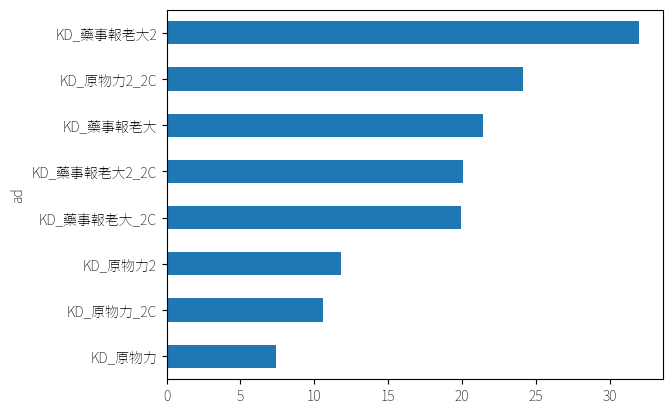

In [28]:
data['ad_score'].groupby(data['ad']).mean().sort_values().plot(kind='barh')

In [30]:
data[['ctr_score', 'watch_score', 'efficiency_score', 'confidence', 'ad_score', 'unweighted_ad_score']].groupby(data['ad']).mean().sort_values(by='ctr_score').to_excel('kd-score-202509.xlsx')

In [15]:
data.to_excel('kd_calculated.xlsx')

In [165]:
data[['cpm']].replace(float("inf"), 0).groupby(data['ad']).mean().sort_values(by='cpm', ascending=False)

,cpm
ad,
PCT-II_第四集,144.644686
PCT-II_第三集,132.812871
PCT-II_Youtube3,121.548520
PCT-II_Youtube3_2B,118.310120
PCT-II_第一集,105.757820
PCT-II_Youtube4,99.608445
PCT-II_Youtube4_2B,99.583450
PCT-II_Youtube2,94.842375
PCT-II_Youtube2_2B,67.988262


In [73]:
data.drop(columns=['raw_ctr_score'], axis=1, inplace=True)

In [ ]:
"""
def quality_score(ad, baselines, priors, k=10000, wA=0.4, wE=0.4, wF=0.2):
    impr = max(ad.impressions, 1)
    clicks = ad.clicks
    cpm = max(ad.cpm, 1e-6)
    avg_wt = ad.avg_watch_time_sec
    L = max(ad.video_length_sec, 1)

    # Priors
    a0, b0 = priors.alpha_ctr, priors.beta_ctr

    # Smoothed CTR
    ctr_star = (clicks + a0) / (impr + a0 + b0)

    # Watch rate
    wr = min(1.0, avg_wt / L)

    # Normalizations
    A = clip(0.5 + 0.2 * log(ctr_star / baselines.median_ctr), 0, 1)
    E = clip(0.5 + 0.2 * log(wr / baselines.median_wr), 0, 1)
    F = clip(0.5 + 0.2 * log(baselines.median_cpm / cpm), 0, 1)

    # Confidence
    C = 1 - exp(-impr / k)

    base = (wA*A + wE*E + wF*F) / (wA + wE + wF)
    return 100 * C * base

""" 

In [ ]:
# curl -G \
#   -d "date_preset=last_7d" \
#   -d "access_token=ACCESS_TOKEN" \
#   "https://graph.facebook.com/API_VERSION/AD_CAMPAIGN_ID/insights"

In [14]:
!curl -X GET -G \
  -d 'effective_status=["ACTIVE"]' \
  -d 'fields="name,objective"' \
  -d 'access_token=EAAUFu3CeRlgBPa3IGxHtR2nGZCprLqZCJYZBFvYeQGjvkGaySN47XgZBkaBCR1KkaWVf0ZBHIM6Y5i9336O8CAP7xQ0Ud2RzQkDW0l7vrUndZCtB76OiP8wgmT45Ge7dXTb3rS2S0i2mJ2hKSyUW3j7xpeZCiNwvfM08utXo1aDcGJlZBZAnAzBlIU07AarZAocllVfRtT5s3ZCiLtuOfHxBma6HLe4' \
  https://graph.facebook.com/v23.0/act_954972373262028/campaigns

{"error":{"message":"Syntax error \"Expected end of string instead of \"e\".\" at character 4: \"name,objective\"","type":"OAuthException","code":2500,"fbtrace_id":"AyPXP9LmS74dskJh1TS4hNB"}}

In [11]:
# EAAUFu3CeRlgBPa3IGxHtR2nGZCprLqZCJYZBFvYeQGjvkGaySN47XgZBkaBCR1KkaWVf0ZBHIM6Y5i9336O8CAP7xQ0Ud2RzQkDW0l7vrUndZCtB76OiP8wgmT45Ge7dXTb3rS2S0i2mJ2hKSyUW3j7xpeZCiNwvfM08utXo1aDcGJlZBZAnAzBlIU07AarZAocllVfRtT5s3ZCiLtuOfHxBma6HLe4

!curl -G \
    -d "level=ad" \
    -d "fields=impressions,clicks,cpm,age" \
    -d "breakdown=age" \
    -d "access_token=EAAUFu3CeRlgBPa3IGxHtR2nGZCprLqZCJYZBFvYeQGjvkGaySN47XgZBkaBCR1KkaWVf0ZBHIM6Y5i9336O8CAP7xQ0Ud2RzQkDW0l7vrUndZCtB76OiP8wgmT45Ge7dXTb3rS2S0i2mJ2hKSyUW3j7xpeZCiNwvfM08utXo1aDcGJlZBZAnAzBlIU07AarZAocllVfRtT5s3ZCiLtuOfHxBma6HLe4" \
    "https://graph.facebook.com/v23.0/120234382627490231/insights"

{"error":{"message":"(#100) age is not valid for fields param. please check https:\/\/developers.facebook.com\/docs\/marketing-api\/reference\/ads-insights\/ for all valid values","type":"OAuthException","code":100,"fbtrace_id":"ARx3ddAjlqf-S6k-eJLDh3w"}}

In [50]:
from facebook_business.api import FacebookAdsApi
from facebook_business.adobjects.adaccount import AdAccount

my_app_id = '1413677489997400'
my_app_secret = '74a83469a416fcc5ab6ecdc03adc1f2b'
my_access_token = 'EAAUFu3CeRlgBPa3IGxHtR2nGZCprLqZCJYZBFvYeQGjvkGaySN47XgZBkaBCR1KkaWVf0ZBHIM6Y5i9336O8CAP7xQ0Ud2RzQkDW0l7vrUndZCtB76OiP8wgmT45Ge7dXTb3rS2S0i2mJ2hKSyUW3j7xpeZCiNwvfM08utXo1aDcGJlZBZAnAzBlIU07AarZAocllVfRtT5s3ZCiLtuOfHxBma6HLe4'

FacebookAdsApi.init(my_app_id, my_app_secret, my_access_token)
my_account = AdAccount('act_954972373262028')
campaigns = my_account.get_campaigns(fields=['name', "effective_status"])
print(campaigns)

[<Campaign> {
    "effective_status": "ACTIVE",
    "id": "120234382627490231",
    "name": "\u548c\u53f8\u7279_Alga3\u85fb\u6cb9_Youtube"
}, <Campaign> {
    "effective_status": "ACTIVE",
    "id": "120233394311110231",
    "name": "\u548c\u53f8\u7279_KD\u9b5a\u6cb9_Youtube"
}, <Campaign> {
    "effective_status": "PAUSED",
    "id": "120232752158530231",
    "name": "\u548c\u53f8\u7279_\u751f\u6280\u5c55\u56de\u9867_Meta"
}, <Campaign> {
    "effective_status": "PAUSED",
    "id": "120231206290050231",
    "name": "\u548c\u53f8\u7279_\u751f\u6280\u5c55_Line@"
}, <Campaign> {
    "effective_status": "ACTIVE",
    "id": "120231030291890231",
    "name": "\u548c\u53f8\u7279_Probiotical_2_Youtube"
}, <Campaign> {
    "effective_status": "ACTIVE",
    "id": "120222167518990231",
    "name": "\u548c\u53f8\u7279_PCT-II_2_Line@"
}, <Campaign> {
    "effective_status": "PAUSED",
    "id": "120220728540960231",
    "name": "\u548c\u53f8\u7279_Probiotical_Line@"
}, <Campaign> {
    "effective_s

In [51]:
for campaign in campaigns:
    print(campaign['name'])

和司特_Alga3藻油_Youtube
和司特_KD魚油_Youtube
和司特_生技展回顧_Meta
和司特_生技展_Line@
和司特_Probiotical_2_Youtube
和司特_PCT-II_2_Line@
和司特_Probiotical_Line@
和司特_PCT-II_Line@
和司特_買萬送萬2_Line@
和司特_買萬送萬_網站CPC


In [27]:
my_account.get_ad_sets(fields=['name', 'effective_status'], 
                       params={"effective_status": ["ACTIVE"]})

[<AdSet> {
    "effective_status": "ACTIVE",
    "id": "120234382627590231",
    "name": "\u548c\u53f8\u7279_Alga3\u85fb\u6cb9_20250829_B2B"
}, <AdSet> {
    "effective_status": "ACTIVE",
    "id": "120234382627530231",
    "name": "\u548c\u53f8\u7279_Alga3\u85fb\u6cb9_20250829_\u518d\u884c\u92b7"
}, <AdSet> {
    "effective_status": "ACTIVE",
    "id": "120234382627510231",
    "name": "\u548c\u53f8\u7279_Alga3\u85fb\u6cb9_20250829_2C"
}, <AdSet> {
    "effective_status": "ACTIVE",
    "id": "120233395572420231",
    "name": "\u548c\u53f8\u7279_KD\u9b5a\u6cb9_20250813_\u518d\u884c\u92b7"
}, <AdSet> {
    "effective_status": "ACTIVE",
    "id": "120233395127650231",
    "name": "\u548c\u53f8\u7279_KD\u9b5a\u6cb9_20250813_2C"
}, <AdSet> {
    "effective_status": "ACTIVE",
    "id": "120233394311130231",
    "name": "\u548c\u53f8\u7279_KD\u9b5a\u6cb9_20250813_B2B"
}, <AdSet> {
    "effective_status": "ACTIVE",
    "id": "120232949587120231",
    "name": "\u548c\u53f8\u7279_Probiotical_20

In [22]:
print(u"\u548c\u53f8\u7279_Alga3\u85fb\u6cb9_Youtube")

和司特_Alga3藻油_Youtube


In [18]:
dir(my_account)

['AccountStatus',
 'ActionSource',
 'AgencyClientDeclaration',
 'BrandSafetyContentFilterLevels',
 'Capabilities',
 'ClaimObjective',
 'ContentType',
 'Currency',
 'Field',
 'PermittedTasks',
 'Subtype',
 'Tasks',
 'TaxIdStatus',
 '_MutableMapping__marker',
 '__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_abc_impl',
 '_api',
 '_assign_fields_to_params',
 '_changes',
 '_clear_history',
 '_data',
 '_default_read_fields',
 '_field_checker',
 '_field_types',
 '_get_field_enum

In [ ]:
"120234382627590231" # alga3 

"120233395127650231" # kd

"120232949587120231" # probiotical
    
"120222167518980231" # pct-2


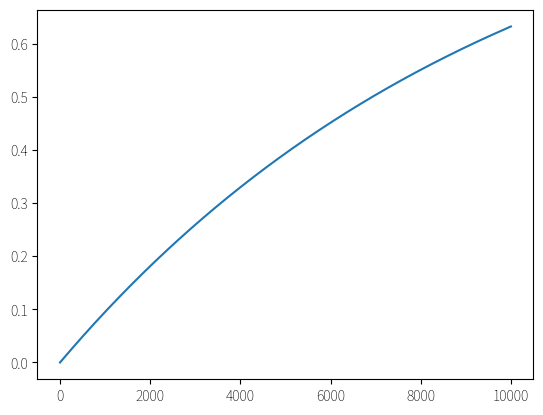

In [ ]:
def d(impr):
    return 1 - np.exp(-impr / 10000)

plt.plot([a for a in range(0, 10000)], [d(a) for a in range(0, 10000)])

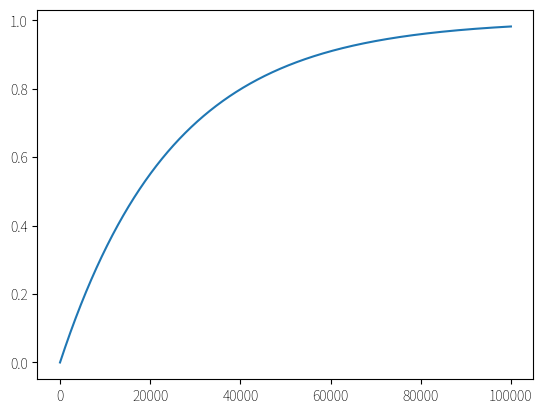

In [177]:
def d(impr):
    return 1 - np.exp(-impr / 25000)

plt.plot([a for a in range(0, 100000)], [d(a) for a in range(0, 100000)])

In [40]:
import numpy as np
from scipy.special import digamma, polygamma

def mle_beta_binomial_newton(imprs, clicks, max_iter=200, tol=1e-8):
    """Estimate alpha,beta via Newton-Raphson maximizing Beta-Binomial likelihood."""
    imprs = np.asarray(imprs, dtype=np.int64)
    clicks = np.asarray(clicks, dtype=np.int64)
    n = len(imprs)

    # sensible init using method-of-moments (weighted)
    total_impr = imprs.sum()
    p = clicks / imprs
    m = clicks.sum() / total_impr
    v = np.sum(imprs * (p - m)**2) / total_impr
    # guard against tiny/zero variance
    if v <= 0:
        alpha = 1.0
        beta = 1.0
    else:
        t = max(m*(1-m)/v - 1.0, 1e-6)
        alpha = max(m * t, 1e-6)
        beta = max((1-m) * t, 1e-6)

    for _ in range(max_iter):
        # gradient
        g_alpha = np.sum(digamma(clicks + alpha) - digamma(imprs + alpha + beta)) + n*(digamma(alpha + beta) - digamma(alpha))
        g_beta  = np.sum(digamma(imprs - clicks + beta) - digamma(imprs + alpha + beta)) + n*(digamma(alpha + beta) - digamma(beta))
        # Hessian (2x2)
        h_aa = np.sum(polygamma(1, clicks + alpha) - polygamma(1, imprs + alpha + beta)) + n*(polygamma(1, alpha + beta) - polygamma(1, alpha))
        h_bb = np.sum(polygamma(1, imprs - clicks + beta) - polygamma(1, imprs + alpha + beta)) + n*(polygamma(1, alpha + beta) - polygamma(1, beta))
        h_ab = np.sum(-polygamma(1, imprs + alpha + beta)) + n*polygamma(1, alpha + beta)

        H = np.array([[h_aa, h_ab],
                      [h_ab, h_bb]], dtype=float)
        g = np.array([g_alpha, g_beta], dtype=float)

        # solve for delta: H delta = g  -> delta = H^{-1} g
        # Newton step: new_params = params - delta
        try:
            delta = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            # fallback tiny step if Hessian singular
            delta = g * 1e-3

        alpha_new = alpha - delta[0]
        beta_new  = beta  - delta[1]

        # keep strictly positive
        alpha_new = max(alpha_new, 1e-9)
        beta_new  = max(beta_new, 1e-9)

        if abs(alpha_new - alpha) < tol and abs(beta_new - beta) < tol:
            alpha, beta = alpha_new, beta_new
            break

        alpha, beta = alpha_new, beta_new

    return alpha, beta

def smoothed_ctr(imprs, clicks, alpha, beta):
    imprs = np.asarray(imprs, dtype=float)
    clicks = np.asarray(clicks, dtype=float)
    return (clicks + alpha) / (imprs + alpha + beta)

alpha = 1.0
beta = 1.0

smoothed_ctr(
    np.array([75, 2, 26, 3]), 
    np.array([10, 0, 2, 0]), 
    alpha,
    beta
)

array([0.14285714, 0.25      , 0.10714286, 0.2       ])

In [35]:
data['_ctr'] = smoothed_ctr(data['impression'].to_numpy(), data['link_clicks'].to_numpy(), alpha, beta)
data

,ad,date,link_clicks,impression,cpm,avg_play_time,total_time,_ctr
0,和司特_PCT-II_Youtube2,2025-08-31,10.0,75,213.333333,5.0,31,0.142857
1,和司特_PCT-II_Youtube2,2025-08-28,0.0,2,0.000000,2.0,31,0.250000
2,和司特_PCT-II_Youtube2,2025-08-27,2.0,26,153.846154,12.0,31,0.107143
3,和司特_PCT-II_Youtube2,2025-08-25,0.0,3,0.000000,2.0,31,0.200000
4,和司特_PCT-II_Youtube2,2025-08-24,0.0,10,0.000000,5.0,31,0.083333
...,...,...,...,...,...,...,...,...
336,和司特_PCT-II_第四集_2B,2025-08-03,5.0,397,62.972292,3.0,52,0.015038
337,和司特_PCT-II_第四集_2B,2025-08-02,2.0,569,3.514938,0.0,52,0.005254
338,和司特_PCT-II_第四集_2B,2025-08-02,24.0,1188,67.340067,3.0,52,0.021008
339,和司特_PCT-II_第四集_2B,2025-08-01,0.0,131,53.435114,4.0,52,0.007519


In [21]:
smoothed_ctr(data['impression'], data['link_clicks'], alpha, beta)

0      0.688666
1      0.811280
2      0.761711
3      0.808818
4      0.791990
         ...   
336    0.375236
337    0.299809
338    0.191795
339    0.582500
340    0.416452
Length: 341, dtype: float64

In [31]:
# 示例点击次数和展示次数数据
impressions = np.array([100, 200, 50, 10, 5])
clicks = np.array([5, 10, 3, 1, 0])
 
# 估计 alpha 和 beta
alpha, beta = bayesian_smoothing(impressions, clicks)
print(f"Estimated alpha: {alpha}, beta: {beta}")
 
# 计算平滑的点击率
smoothed_click_through_rate = smoothed_ctr(impressions, clicks, alpha, beta)
print("平滑后的点击率：", smoothed_click_through_rate)

Estimated alpha: 119.65437956007789, beta: 14.055344061471015
平滑后的点击率： [0.53337267 0.38852443 0.66765317 0.83957005 0.86262431]


In [48]:
import numpy as np
from scipy.special import gammaln
from scipy.optimize import minimize

def neg_log_likelihood_logparams(log_params, impressions, clicks):
    alpha = np.exp(log_params[0])
    beta = np.exp(log_params[1])
    im = impressions.astype(np.int64)
    r = clicks.astype(np.int64)
    term1 = gammaln(r + alpha) + gammaln(im - r + beta) - gammaln(im + alpha + beta)
    term2 = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    ll = np.sum(term1 - term2)
    return -ll

def init_moments(impressions, clicks):
    im = impressions.astype(float)
    r = clicks.astype(float)
    total_impr = im.sum()
    p = np.where(im > 0, r / im, 0.0)
    m = r.sum() / total_impr
    v_num = np.sum(im * (p - m) ** 2)
    v = v_num / total_impr
    if v <= 0 or m * (1 - m) / v <= 1:
        return 1.0, 1.0
    t = max(m * (1 - m) / v - 1.0, 1e-6)
    alpha = max(m * t, 1e-6)
    beta = max((1 - m) * t, 1e-6)
    return alpha, beta

def estimate_ab_by_opt(impressions, clicks, method="L-BFGS-B"):
    impressions = np.asarray(impressions, dtype=np.int64)
    clicks = np.asarray(clicks, dtype=np.int64)
    alpha0, beta0 = init_moments(impressions, clicks)
    x0 = np.log([alpha0, beta0])
    res = minimize(
        fun=neg_log_likelihood_logparams,
        x0=x0,
        args=(impressions, clicks),
        method=method,
        bounds=[(-30, 30), (-30, 30)],
        options={"maxiter": 10000}
    )
    if not res.success:
        res = minimize(
            fun=neg_log_likelihood_logparams,
            x0=x0,
            args=(impressions, clicks),
            method="Nelder-Mead",
            options={"maxiter": 20000}
        )
    alpha_hat = float(np.exp(res.x[0]))
    beta_hat = float(np.exp(res.x[1]))
    return alpha_hat, beta_hat, res

def smoothed_ctr(impressions, clicks, alpha, beta):
    im = np.asarray(impressions, dtype=float)
    r = np.asarray(clicks, dtype=float)
    return (r + alpha) / (im + alpha + beta)

impressions = np.array([100, 200, 50, 10, 5, 100])
clicks = np.array([5, 10, 3, 1, 0, 100])
alpha_hat, beta_hat, res = estimate_ab_by_opt(impressions, clicks)
prior_mean = alpha_hat / (alpha_hat + beta_hat)
smoothed = smoothed_ctr(impressions, clicks, alpha_hat, beta_hat)

print("Optimization success:", res.success)
print("Message:", res.message)
print(f"Estimated alpha: {alpha_hat:.6f}, beta: {beta_hat:.6f}")
print(f"Prior mean (alpha/(alpha+beta)): {prior_mean:.6f}")
print("Smoothed CTRs for each (impr, clicks):")
for im, r, s in zip(impressions, clicks, smoothed):
    print(f"  ({im}, {r}) -> {s:.6f}")

global_ctr = clicks.sum() / impressions.sum()
print(f"\nGlobal CTR (total clicks / total impressions): {global_ctr:.6f}")


Optimization success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Estimated alpha: 0.236581, beta: 0.366043
Prior mean (alpha/(alpha+beta)): 0.392585
Smoothed CTRs for each (impr, clicks):
  (100, 5) -> 0.052052
  (200, 10) -> 0.051029
  (50, 3) -> 0.063961
  (10, 1) -> 0.116630
  (5, 0) -> 0.042227
  (100, 100) -> 0.996361

Global CTR (total clicks / total impressions): 0.255914


In [47]:
data.groupby('ad')['_ctr'].mean() 

ad
和司特_PCT-II_Youtube2       0.113167
和司特_PCT-II_Youtube2_2B    0.087309
和司特_PCT-II_Youtube3       0.065930
和司特_PCT-II_Youtube3_2B    0.069678
和司特_PCT-II_Youtube4       0.062729
和司特_PCT-II_Youtube4_2B    0.079862
和司特_PCT-II_第一集            0.173510
和司特_PCT-II_第一集_2B         0.069699
和司特_PCT-II_第三集            0.154957
和司特_PCT-II_第三集_2B         0.093557
和司特_PCT-II_第四集            0.106711
和司特_PCT-II_第四集_2B         0.091487
Name: _ctr, dtype: float64

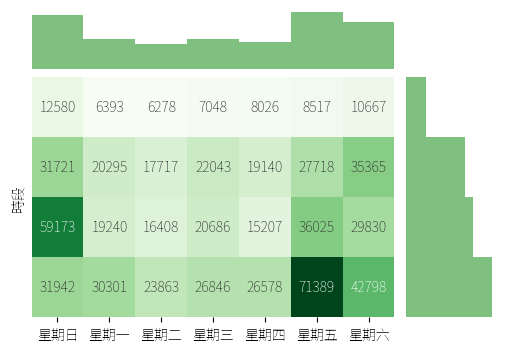

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# Data
data = {
    "時段": ["00-06", "06-12", "12-18", "18-24"],
    "星期日": [12580, 31721, 59173, 31942],
    "星期一": [6393, 20295, 19240, 30301],
    "星期二": [6278, 17717, 16408, 23863],
    "星期三": [7048, 22043, 20686, 26846],
    "星期四": [8026, 19140, 15207, 26578],
    "星期五": [8517, 27718, 36025, 71389],
    "星期六": [10667, 35365, 29830, 42798],
}
df = pd.DataFrame(data).set_index("時段")

# Aggregates
row_sums = df.sum(axis=1)
col_sums = df.sum(axis=0)

# Layout
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                      wspace=0.05, hspace=0.05)

# Heatmap
ax_main = fig.add_subplot(gs[1, 0])
sns.heatmap(df, cmap="Greens", annot=True, fmt="d", cbar=False, ax=ax_main)

# Top bar — aligned with columns
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.bar(range(len(col_sums)), col_sums, width=1, color="green", align='edge', alpha=0.5)
ax_top.set_yticks([])
ax_top.axis('off')

# Right bar — aligned with rows
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_right.barh(range(len(row_sums)), row_sums, height=1, color="green", align='edge', alpha=0.5)
ax_right.set_xticks([])
ax_right.set_yticks([])
ax_right.axis('off')

plt.show()